## Part 2: Experiment Analysis and Visualization
This notebook loads the pre-computed models and datasets to perform the final analysis. It generates the key insights and visualizations for the project, including SHAP plots and geospatial maps.

In [ ]:

"""
Notes before running:

- This notebook loads the pre-computed results from the main model pipeline
to perform analysis and generate visualizations without re-training models.
- Remember to replace the base folder if you have it under colab and under 631, rember to add/631/ on your end

"""

# Step 1: Install necessary libraries
!pip install pandas matplotlib seaborn plotly geopandas joblib shap

# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import joblib
import shap




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Define the base path to the project folder here
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/"
# --- EXPERIMENT 1: DEFINE AND PROFILE CUSTOMER SEGMENTS ---

print("--- Running Experiment 1: Profiling Customer Segments ---")

# Load the final clustered dataset
try:
    df_clusters = pd.read_csv(f"{BASE_PATH}trained_results/retail_with_clusters(P).csv")

    # Filter out noise points from HDBSCAN (where Cluster_ID is -1)
    df_filtered = df_clusters[df_clusters['Cluster_ID'] != -1].copy()

    # Group by Cluster_ID to calculate the profile of each segment
    cluster_profiles = df_filtered.groupby('Cluster_ID').agg(
        Size=('Customer_ID', 'count'),
        Avg_Total_Purchases=('Total_Purchases', 'mean'),
        Avg_Total_Amount=('Total_Amount', 'mean'),
        Avg_Age=('Age', 'mean'),
        Avg_Positive_Prob=('Positive_Prob', 'mean')
    ).round(2)

    # Display the top 5 largest customer segments by their average spending
    print("Customer Segment Profiles (Top 5 largest segments sorted by average spend):")
    top_5_largest_clusters = cluster_profiles.nlargest(5, 'Size')
    print(top_5_largest_clusters.sort_values(by='Avg_Total_Amount', ascending=False))
    print("-" * 50)

except FileNotFoundError:
    print("Error: retail_with_clusters(P).csv not found. Please check the BASE_PATH.")


--- Running Experiment 1: Profiling Customer Segments ---
Customer Segment Profiles (Top 5 largest segments sorted by average spend):
            Size  Avg_Total_Purchases  Avg_Total_Amount  Avg_Age  \
Cluster_ID                                                         
567         1536                 8.86           2293.88    55.39   
7           1628                 8.00           2017.38    21.46   
54          1789                 7.00           1804.26    38.20   
14          1143                 7.00           1327.98    21.49   
123         1022                 3.00            446.76    31.12   

            Avg_Positive_Prob  
Cluster_ID                     
567                      0.00  
7                        0.00  
54                       0.00  
14                       0.00  
123                      0.48  
--------------------------------------------------



--- Running Experiment 2: SHAP-Based Explainability ---
Generating SHAP Beeswarm Plot for detailed insights...


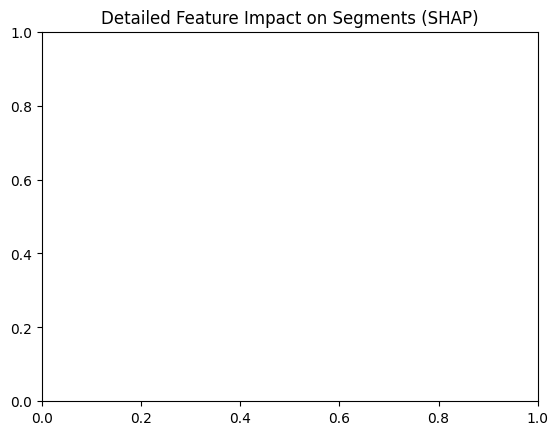

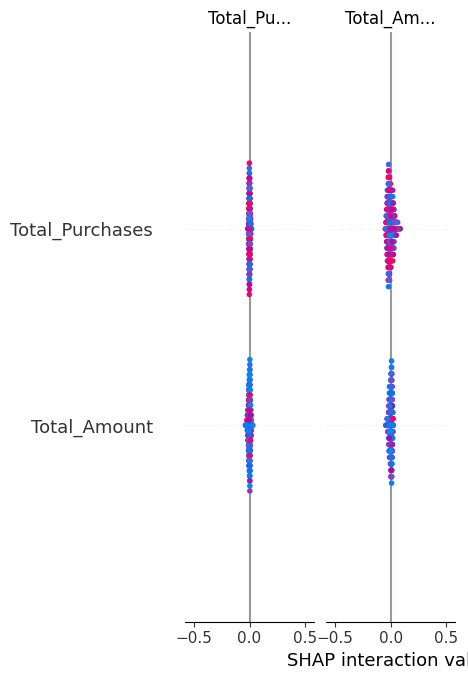

--------------------------------------------------


In [ ]:
# --- EXPERIMENT 2: EXPLAIN "WHY" WITH SHAP VISUALIZATIONS ---
print("\n--- Running Experiment 2: SHAP-Based Explainability ---")

try:
    # Load the trained model, SHAP values, and a sample of the data
    rf_model = joblib.load(f"{BASE_PATH}Everything- 631/trained_models-20251018T003846Z-1-001/trained_models/randomforest_cluster_model.pkl")
    shap_values = joblib.load(f"{BASE_PATH}Everything- 631/trained_results-20251018T003848Z-1-001/trained_results/shap_values_rf.pkl")

    # Recreate the exact feature set used for the SHAP calculation
    features_for_shap = ["Total_Purchases", "Total_Amount", "Age", "Positive_Prob"]
    # Use the same sample size as the loaded shap_values
    X_sample = df_filtered[features_for_shap].sample(n=shap_values.shape[0], random_state=42)

    # Plot : Detailed Feature Impact (Beeswarm Plot)
    print("Generating SHAP Beeswarm Plot for detailed insights...")
    plt.title("Detailed Feature Impact on Segments (SHAP)")
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.savefig(f"{BASE_PATH}trained_results/shap_beeswarm_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("-" * 50)

except FileNotFoundError:
    print("Error: One or more SHAP files not found. Please check the BASE_PATH.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Running Experiment 3: Spatial Analysis of Segments ---
Generating Geographic Distribution Map...


--------------------------------------------------

--- Running Experiment 4: Linking Sentiment to Customer Value ---
Average Spend and Purchases by Customer Sentiment:
  Predicted_Label  Avg_Total_Amount  Avg_Total_Purchases
0        negative           1279.75                 5.27
1         neutral           1433.98                 5.72
2        positive           1244.85                 5.17
Generating Sentiment vs. Spend Plot...


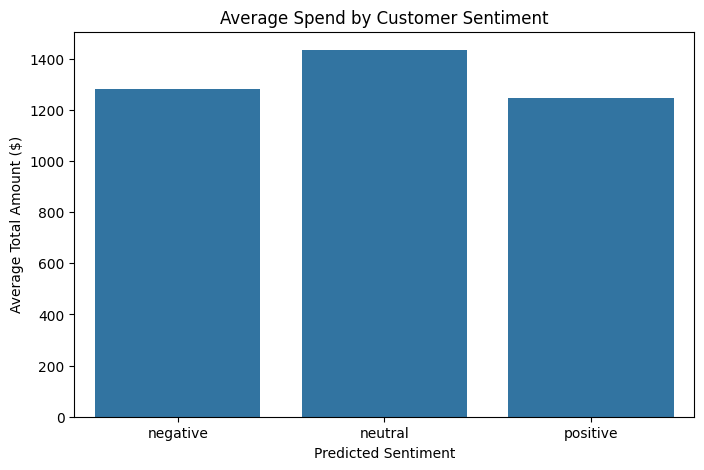

--------------------------------------------------


In [ ]:
# --- EXPERIMENT 3: MAP THE SPATIAL CONNECTIVITY OF BEHAVIOR ---

print("\n--- Running Experiment 3: Spatial Analysis of Segments ---")

try:
    # Use the filtered dataframe from Experiment 1, which has lat/lon
    # Focus on the 5 largest clusters for a clearer map
    top_5_ids = top_5_largest_clusters.index
    df_map = df_filtered[df_filtered['Cluster_ID'].isin(top_5_ids)].copy()

    # To avoid issues with Plotly, ensure Cluster_ID is treated as a category
    df_map['Cluster_ID'] = df_map['Cluster_ID'].astype(str)

    print("Generating Geographic Distribution Map...")
    fig = px.scatter_geo(
        df_map,
        lat='latitude',
        lon='longitude',
        color='Cluster_ID',
        scope='usa',
        title='Geographic Distribution of Top 5 Customer Segments',
        template='seaborn'
    )
    fig.show()
    print("-" * 50)

except Exception as e:
    print(f"An error occurred during map generation: {e}")


# --- EXPERIMENT 4: LINK SENTIMENT DIRECTLY TO BUSINESS VALUE ---

print("\n--- Running Experiment 4: Linking Sentiment to Customer Value ---")

try:
    # Load the dataset with sentiment labels
    df_sentiment = pd.read_csv(f"{BASE_PATH}Everything- 631/trained_results-20251018T003848Z-1-001/trained_results/retail_with_sentiment.csv")

    # Group by sentiment to see the impact on spending and purchases
    sentiment_kpis = df_sentiment.groupby('Predicted_Label').agg(
        Avg_Total_Amount=('Total_Amount', 'mean'),
        Avg_Total_Purchases=('Total_Purchases', 'mean')
    ).round(2).reset_index()

    print("Average Spend and Purchases by Customer Sentiment:")
    print(sentiment_kpis)

    # Visualize the results
    print("Generating Sentiment vs. Spend Plot...")
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=sentiment_kpis,
        x='Predicted_Label',
        y='Avg_Total_Amount',
        order=['negative', 'neutral', 'positive'] # Ensure logical order
    )
    plt.title('Average Spend by Customer Sentiment')
    plt.ylabel('Average Total Amount ($)')
    plt.xlabel('Predicted Sentiment')
    plt.savefig(f"{BASE_PATH}trained_results/sentiment_vs_spend.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("-" * 50)

except FileNotFoundError:
    print("Error: retail_with_sentiment.csv not found. Please check the BASE_PATH.")


--- Alternative Exp A: VIP Driver Analysis ---
VIP Threshold: $3067.75
Is_VIP
0    77310
1     8590
Name: count, dtype: int64


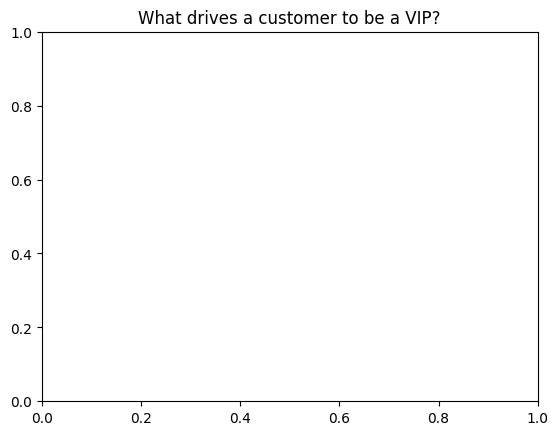

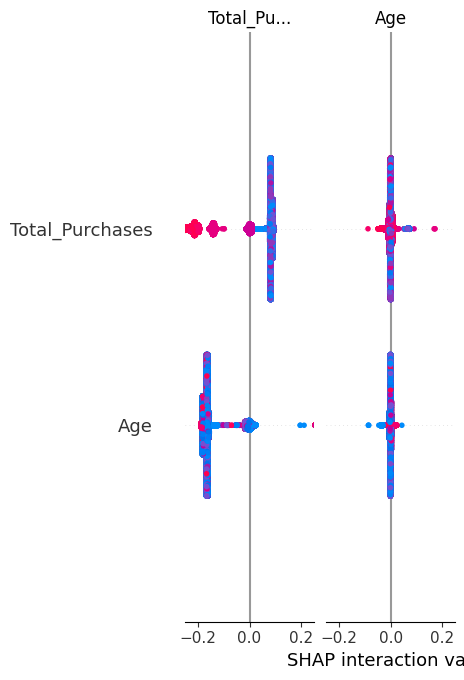

In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- Alternative Exp A: VIP Driver Analysis ---")

# 1. Define VIPs (e.g., top 10% by Total_Amount)
threshold = df_filtered['Total_Amount'].quantile(0.90)
df_filtered['Is_VIP'] = (df_filtered['Total_Amount'] > threshold).astype(int)

print(f"VIP Threshold: ${threshold:.2f}")
print(df_filtered['Is_VIP'].value_counts())

# 2. Train a quick specialized model just for this experiment
features = ["Total_Purchases", "Age", "Positive_Prob"] # Exclude Total_Amount as it defines the group!
X_vip = df_filtered[features]
y_vip = df_filtered['Is_VIP']

rf_vip = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf_vip.fit(X_vip, y_vip)

# 3. SHAP for VIPs
explainer_vip = shap.TreeExplainer(rf_vip)
shap_values_vip = explainer_vip.shap_values(X_vip)

# Plotting Class 1 (VIPs)
plt.figure()
plt.title("What drives a customer to be a VIP?")
# Note: binary classification SHAP sometimes returns a list [Class0, Class1], sometimes just one array.
if isinstance(shap_values_vip, list):
     shap.summary_plot(shap_values_vip[1], X_vip, show=False)
else:
     shap.summary_plot(shap_values_vip, X_vip, show=False)

plt.show()

In [ ]:


print("\n--- Running Fine-Tuned Experiment B: State Sentiment Heatmap ---")

# Define the base path to your project folder
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/" # Make sure this path is correct!

try:
    # Load your dataset with sentiment scores
    df_sentiment = pd.read_csv(f"{BASE_PATH}Everything- 631/trained_results-20251018T003848Z-1-001/trained_results/retail_with_sentiment.csv")

    # 1. Aggregate sentiment by state
    # This gives us a DataFrame with 'State' (full name) and 'Positive_Prob'
    state_sentiment = df_sentiment.groupby('State')['Positive_Prob'].mean().reset_index()

    # 2. Create the mapping dictionary from full state names to 2-letter codes
    state_code_map = {
        'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AR', 'california': 'CA',
        'colorado': 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
        'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA',
        'kansas': 'KS', 'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
        'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS',
        'missouri': 'MO', 'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'new hampshire': 'NH',
        'new jersey': 'NJ', 'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC',
        'north dakota': 'ND', 'ohio': 'OH', 'oklahoma': 'OK', 'oregon': 'OR', 'pennsylvania': 'PA',
        'rhode island': 'RI', 'south carolina': 'SC', 'south dakota': 'SD', 'tennessee': 'TN',
        'texas': 'TX', 'utah': 'UT', 'vermont': 'VT', 'virginia': 'VA', 'washington': 'WA',
        'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY',
        # Add District of Columbia if it exists in your data
        'district of columbia': 'DC'
    }

    # 3. Apply the map to create a new 'State_Code' column
    # We use .str.lower() to ensure matching, as your data is lowercased.
    state_sentiment['State_Code'] = state_sentiment['State'].str.lower().map(state_code_map)

    # --- DIAGNOSTIC STEP ---
    # Check if the mapping worked and if there are any states that weren't mapped.
    print("Data after mapping (first 10 rows):")
    print(state_sentiment.head(10))

    unmapped_states = state_sentiment[state_sentiment['State_Code'].isnull()]
    if not unmapped_states.empty:
        print("\nWARNING: The following states could not be mapped to a code:")
        print(unmapped_states)
    else:
        print("\nSUCCESS: All states mapped successfully. Except Tennesse & SC not in our dataset")
    # --- END DIAGNOSTIC ---


    # 4. Plot the choropleth map using the NEW 'State_Code' column
    fig = px.choropleth(
        state_sentiment,
        locations='State_Code',           # Use the 2-letter code column
        locationmode="USA-states",      # This tells Plotly to expect 2-letter codes
        color='Positive_Prob',          # The value to color the states by
        scope="usa",                    # Focus the map on the USA
        color_continuous_scale="RdYlGn",# Red (low) -> Yellow (mid) -> Green (high)
        title='Average Customer Sentiment by State',
        labels={'Positive_Prob': 'Avg. Sentiment'} # Legend title
    )
    fig.show()

except FileNotFoundError:
    print(f"Error: Could not find data at {BASE_PATH}. Please verify the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Running Fine-Tuned Experiment B: State Sentiment Heatmap ---
Data after mapping (first 10 rows):
         State  Positive_Prob State_Code
0      alabama       0.736132         AL
1       alaska       0.476897         AK
2      arizona       0.239235         AZ
3     arkansas       0.498487         AR
4   california       0.498454         CA
5     colorado       0.399097         CO
6  connecticut       0.476883         CT
7     delaware       0.596903         DE
8      florida       0.368836         FL
9      georgia       0.420296         GA

SUCCESS: All states mapped successfully. Except Tennesse & SC not in our dataset


In [ ]:
df_sentiment.head()

,Transaction_ID,Customer_ID,State,Zipcode,Country,Age,Gender,Date,Year,Month,...,Product_Type,Feedback,Payment_Method,Ratings,products,label_str,label,Segment_ID,Predicted_Label,Positive_Prob
0,7399477.0,73067.0,vermont,5243.0,usa,30.0,0.0,9/26/2023,2023.0,april,...,mitsubishi 1.5 ton 3 star split ac,excellent,credit card,4.0,floor-standing ac,positive,2,3,positive,0.995368
1,1172159.0,82138.0,kansas,67435.0,usa,34.0,1.0,01-04-24,2024.0,january,...,water,good,paypal,3.0,mineral water,neutral,1,2,neutral,0.476897
2,2513010.0,38743.0,maine,55243.0,usa,26.0,0.0,2/15/2024,2024.0,january,...,fridge,average,debit card,2.0,french door refrigerator,negative,0,0,negative,0.001540
3,5027302.0,32769.0,connecticut,21632.0,usa,20.0,1.0,06-11-23,2023.0,june,...,television,excellent,paypal,5.0,lcd tv,positive,2,2,positive,0.995368
4,5045297.0,65734.0,connecticut,57377.0,usa,34.0,0.0,11/19/2023,2023.0,november,...,shoes,excellent,credit card,5.0,flip flops,positive,2,3,positive,0.995368


In [ ]:
print("\n--- Alternative Exp C: Extreme Sentiment Profiling ---")

# Define extremes (e.g., top 5% and bottom 5% sentiment scores)
top_sent = df_sentiment['Positive_Prob'].quantile(0.95)
bot_sent = df_sentiment['Positive_Prob'].quantile(0.05)

lovers = df_sentiment[df_sentiment['Positive_Prob'] >= top_sent]
haters = df_sentiment[df_sentiment['Positive_Prob'] <= bot_sent]

# Compare their behaviors
print(f"Super Fans (>{top_sent:.2f} prob): Avg Spend = ${lovers['Total_Amount'].mean():.2f}")
print(f"Super Haters (<{bot_sent:.2f} prob): Avg Spend = ${haters['Total_Amount'].mean():.2f}")

# Optional: Compare their product preferences
print("\nTop Product Category for Super Fans:")
print(lovers['Product_Category'].mode()[0])
print("\nTop Product Category for Super Haters:")
print(haters['Product_Category'].mode()[0])


--- Alternative Exp C: Extreme Sentiment Profiling ---
Super Fans (>1.00 prob): Avg Spend = $1244.85
Super Haters (<0.00 prob): Avg Spend = $1329.17

Top Product Category for Super Fans:
home decor

Top Product Category for Super Haters:
clothing



--- Experiment D: Behavioral Segmentation (FM Analysis) ---
Segment Personas created:
FM_Persona
Other                     33391
Low Value                 31545
Champions                 12044
Loyal Spenders             7657
Big Spenders (At Risk)     1263
Name: count, dtype: int64

Average Sentiment of Behavioral Personas:
FM_Persona
Low Value                 0.441235
Big Spenders (At Risk)    0.438216
Champions                 0.436884
Other                     0.430331
Loyal Spenders            0.426731
Name: Positive_Prob, dtype: float64


/tmp/ipython-input-4278375138.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




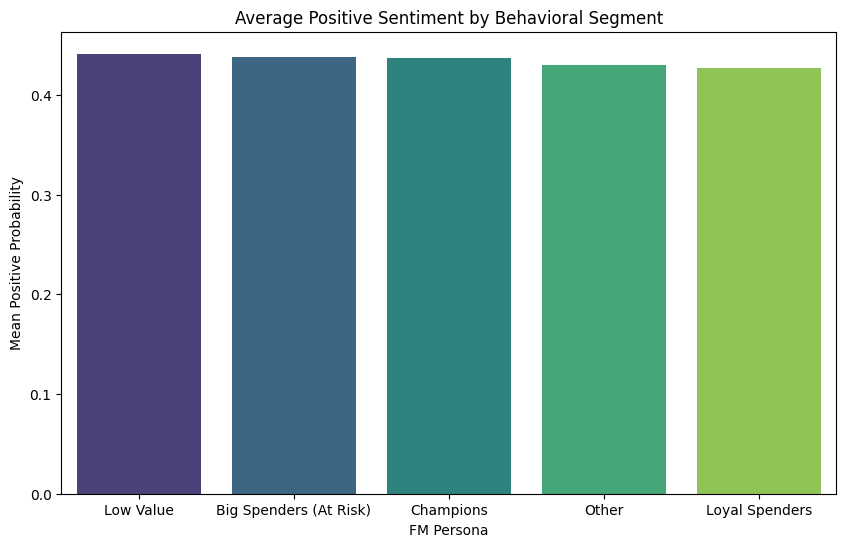

In [ ]:
print("\n--- Experiment D: Behavioral Segmentation (FM Analysis) ---")

# Use the filtered dataframe which has all the necessary columns
# df_filtered is from Experiment 1 (df_clusters[df_clusters['Cluster_ID'] != -1])

# 1. Create Frequency and Monetary quantiles (e.g., 4 tiers from 0 to 3)
df_filtered['M_Score'] = pd.qcut(df_filtered['Total_Amount'], 4, labels=range(4))
df_filtered['F_Score'] = pd.qcut(df_filtered['Total_Purchases'].rank(method='first'), 4, labels=range(4)) # use rank() to handle non-unique bin edges

# 2. Create a combined FM_Segment
df_filtered['FM_Segment'] = df_filtered.apply(lambda row: f"F{row['F_Score']}_M{row['M_Score']}", axis=1)

# Let's define some key segments based on scores
def name_fm_segment(row):
    if row['F_Score'] == 3 and row['M_Score'] == 3:
        return 'Champions'
    if row['F_Score'] == 3 and row['M_Score'] > 0:
        return 'Loyal Spenders'
    if row['F_Score'] < 2 and row['M_Score'] == 3:
        return 'Big Spenders (At Risk)'
    if row['F_Score'] < 2 and row['M_Score'] < 2:
        return 'Low Value'
    return 'Other' # Catch-all for other combinations

df_filtered['FM_Persona'] = df_filtered.apply(name_fm_segment, axis=1)

print("Segment Personas created:")
print(df_filtered['FM_Persona'].value_counts())

# 3. Analyze the sentiment of these new personas
fm_sentiment_profile = df_filtered.groupby('FM_Persona')['Positive_Prob'].mean().sort_values(ascending=False)

print("\nAverage Sentiment of Behavioral Personas:")
print(fm_sentiment_profile)

# 4. Visualize the sentiment profile
plt.figure(figsize=(10, 6))
sns.barplot(x=fm_sentiment_profile.index, y=fm_sentiment_profile.values, palette='viridis')
plt.title('Average Positive Sentiment by Behavioral Segment')
plt.ylabel('Mean Positive Probability')
plt.xlabel('FM Persona')
plt.show()


--- Experiment E: Sentiment-Driven Personas (NPS-Style) ---
Sentiment Persona counts:
Sentiment_Persona
Passive      175
Detractor    175
Promoter     150
Name: count, dtype: int64

Behavioral Profile by Sentiment Persona:
                   Avg_Total_Amount  Avg_Total_Purchases  Avg_Age
Sentiment_Persona                                                
Detractor                   1279.75                 5.27    29.67
Passive                     1433.98                 5.72    33.04
Promoter                    1244.85                 5.17    35.27


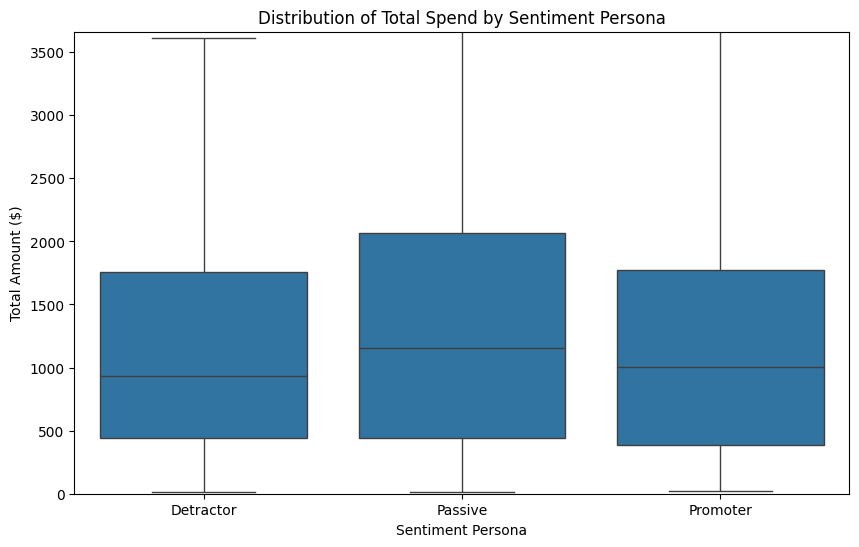

In [ ]:
print("\n--- Experiment E: Sentiment-Driven Personas (NPS-Style) ---")

# Use the sentiment-labeled dataframe
# df_sentiment is from Experiment 4 (pd.read_csv(".../retail_with_sentiment.csv"))

# 1. Define sentiment personas based on Positive_Prob
def sentiment_persona(prob):
    if prob >= 0.7:  # High probability of being positive
        return 'Promoter'
    elif prob <= 0.3: # Low probability of being positive
        return 'Detractor'
    else:
        return 'Passive'

df_sentiment['Sentiment_Persona'] = df_sentiment['Positive_Prob'].apply(sentiment_persona)

print("Sentiment Persona counts:")
print(df_sentiment['Sentiment_Persona'].value_counts())

# 2. Profile the behavior of these personas
sentiment_behavior_profile = df_sentiment.groupby('Sentiment_Persona').agg(
    Avg_Total_Amount=('Total_Amount', 'mean'),
    Avg_Total_Purchases=('Total_Purchases', 'mean'),
    Avg_Age=('Age', 'mean')
).round(2)

print("\nBehavioral Profile by Sentiment Persona:")
print(sentiment_behavior_profile)

# 3. Visualize the difference in spending
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_sentiment, x='Sentiment_Persona', y='Total_Amount',
            order=['Detractor', 'Passive', 'Promoter'])
plt.title('Distribution of Total Spend by Sentiment Persona')
plt.ylabel('Total Amount ($)')
plt.xlabel('Sentiment Persona')
plt.ylim(0, df_sentiment['Total_Amount'].quantile(0.95)) # Zoom in on the bulk of the data
plt.show()


--- Experiment F: Explaining Customer Value with SHAP ---
Regressor model trained to predict Total_Amount.
Generating SHAP plot for Customer Value drivers...


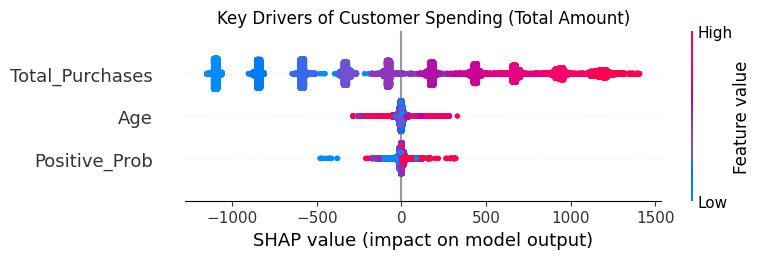

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

print("\n--- Experiment F: Explaining Customer Value with SHAP ---")

# Use the filtered dataframe from previous experiments
features = ['Total_Purchases', 'Age', 'Positive_Prob']
target = 'Total_Amount'

X = df_filtered[features]
y = df_filtered[target]

# 1. Train a simple Regression model to predict Total_Amount
# We use a Regressor, not a Classifier
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
rf_regressor.fit(X, y)

print("Regressor model trained to predict Total_Amount.")

# 2. Apply SHAP to the regressor
explainer = shap.TreeExplainer(rf_regressor)
shap_values_reg = explainer.shap_values(X)

# 3. Create the SHAP summary plot
print("Generating SHAP plot for Customer Value drivers...")
plt.title("Key Drivers of Customer Spending (Total Amount)")
shap.summary_plot(shap_values_reg, X, show=False)
plt.savefig(f"{BASE_PATH}trained_results/shap_customer_value_drivers.png", dpi=300, bbox_inches='tight')
plt.show()


--- Experiment E: Sentiment-Driven Personas (NPS-Style) ---
Sentiment Persona counts:
Sentiment_Persona
Passive      175
Detractor    175
Promoter     150
Name: count, dtype: int64

Behavioral Profile by Sentiment Persona:
                   Avg_Total_Amount  Avg_Total_Purchases  Avg_Age
Sentiment_Persona                                                
Detractor                   1279.75                 5.27    29.67
Passive                     1433.98                 5.72    33.04
Promoter                    1244.85                 5.17    35.27


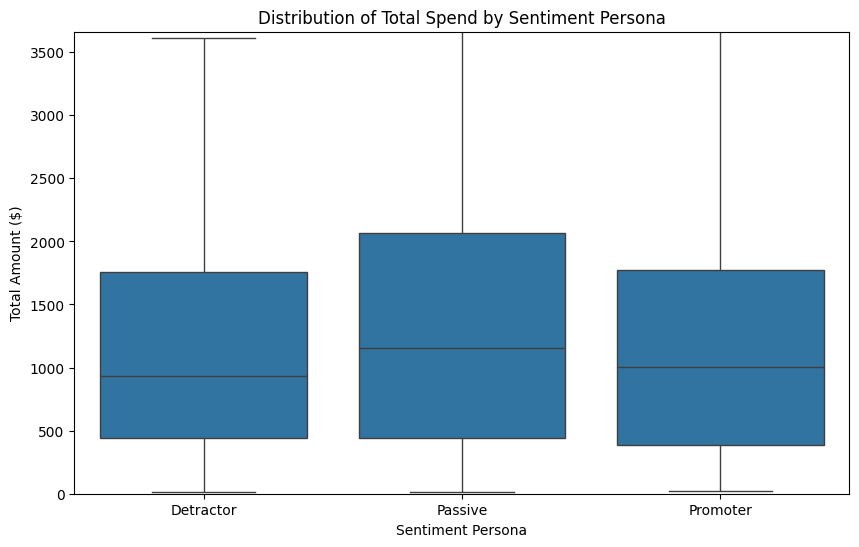

In [ ]:
print("\n--- Experiment E: Sentiment-Driven Personas (NPS-Style) ---")

# Use the sentiment-labeled dataframe
# df_sentiment is from Experiment 4 (pd.read_csv(".../retail_with_sentiment.csv"))

# 1. Define sentiment personas based on Positive_Prob
def sentiment_persona(prob):
    if prob >= 0.7:  # High probability of being positive
        return 'Promoter'
    elif prob <= 0.3: # Low probability of being positive
        return 'Detractor'
    else:
        return 'Passive'

df_sentiment['Sentiment_Persona'] = df_sentiment['Positive_Prob'].apply(sentiment_persona)

print("Sentiment Persona counts:")
print(df_sentiment['Sentiment_Persona'].value_counts())

# 2. Profile the behavior of these personas
sentiment_behavior_profile = df_sentiment.groupby('Sentiment_Persona').agg(
    Avg_Total_Amount=('Total_Amount', 'mean'),
    Avg_Total_Purchases=('Total_Purchases', 'mean'),
    Avg_Age=('Age', 'mean')
).round(2)

print("\nBehavioral Profile by Sentiment Persona:")
print(sentiment_behavior_profile)

# 3. Visualize the difference in spending
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_sentiment, x='Sentiment_Persona', y='Total_Amount',
            order=['Detractor', 'Passive', 'Promoter'])
plt.title('Distribution of Total Spend by Sentiment Persona')
plt.ylabel('Total Amount ($)')
plt.xlabel('Sentiment Persona')
plt.ylim(0, df_sentiment['Total_Amount'].quantile(0.95)) # Zoom in on the bulk of the data
plt.show()


--- Experiment G: Voice of the Customer Word Analysis ---


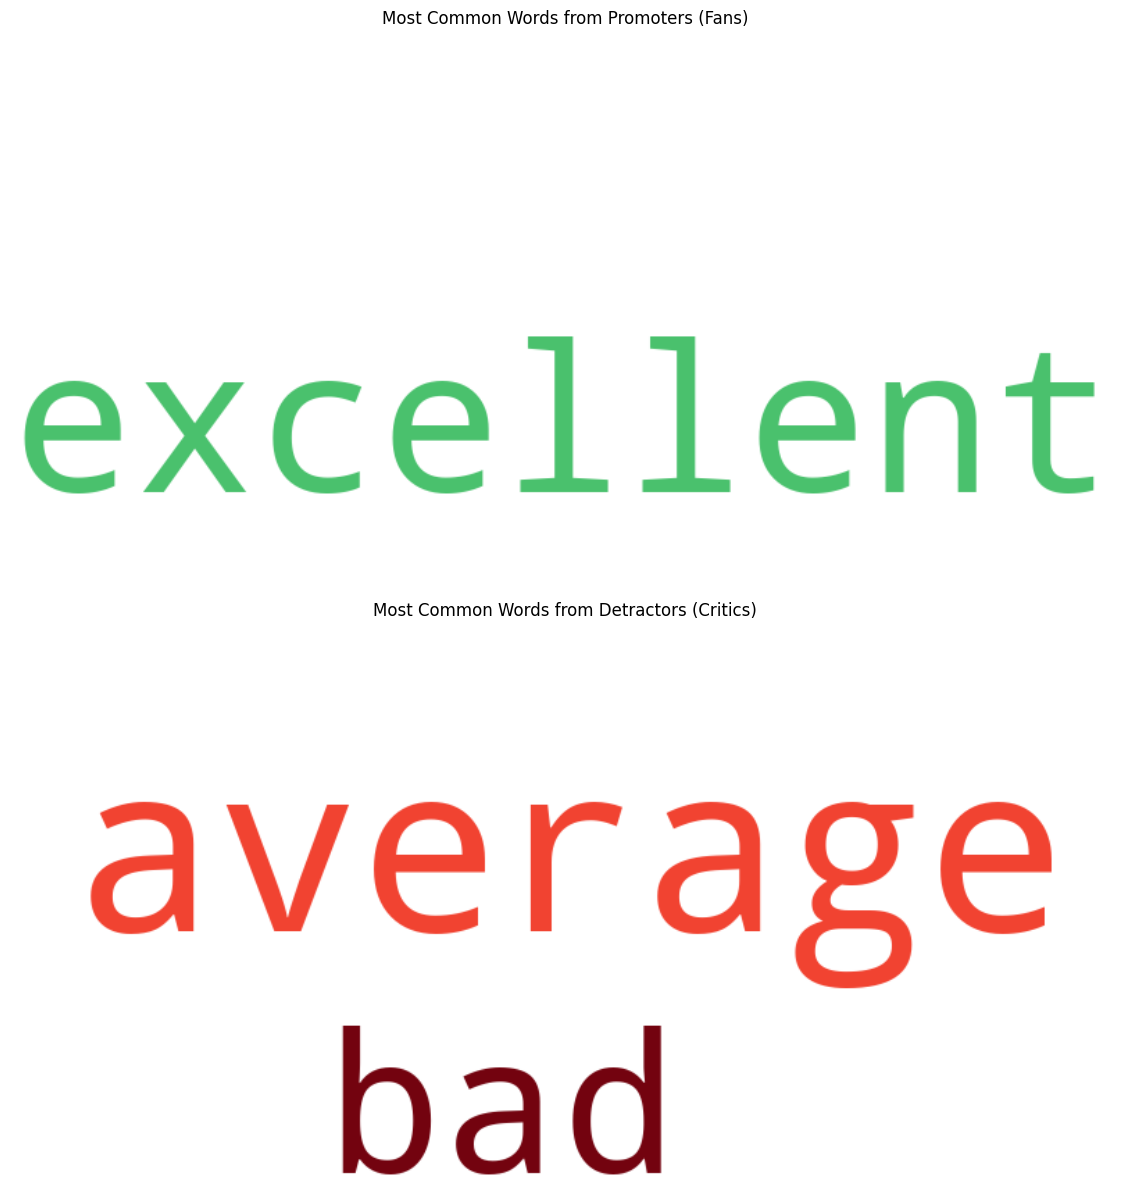

In [ ]:
from wordcloud import WordCloud
import re

print("\n--- Experiment G: Voice of the Customer Word Analysis ---")

# Use the sentiment persona dataframe from Experiment E
promoter_feedback = " ".join(df_sentiment[df_sentiment['Sentiment_Persona'] == 'Promoter']['Feedback'].dropna())
detractor_feedback = " ".join(df_sentiment[df_sentiment['Sentiment_Persona'] == 'Detractor']['Feedback'].dropna())

# Basic text cleaning
promoter_feedback = re.sub(r'[^\w\s]', '', promoter_feedback).lower()
detractor_feedback = re.sub(r'[^\w\s]', '', detractor_feedback).lower()

# Generate Word Clouds
wc_promoter = WordCloud(width=800, height=400, background_color='white').generate(promoter_feedback)
wc_detractor = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(detractor_feedback)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].imshow(wc_promoter, interpolation='bilinear')
axes[0].set_title('Most Common Words from Promoters (Fans)')
axes[0].axis('off')

axes[1].imshow(wc_detractor, interpolation='bilinear')
axes[1].set_title('Most Common Words from Detractors (Critics)')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(f"{BASE_PATH}trained_results/sentiment_word_clouds.png", dpi=300, bbox_inches='tight')
plt.show()

## Notebook Summary (Short Points)

This notebook performs various analyses on customer data:

*   **Customer Segmentation Profiling**: Analyzing characteristics of customer segments.
*   **SHAP-Based Explainability**: Understanding feature importance in segmentation.
*   **Spatial Connectivity Mapping**: Visualizing segment distribution geographically.
*   **Linking Sentiment to Business Value**: Relating customer sentiment to spending and purchases.
*   **VIP Driver Analysis (RFM & SHAP)**: Identifying factors that drive VIP status.
*   **State Sentiment Heatmap**: Mapping average sentiment across states.
*   **Extreme Sentiment Profiling**: Comparing "Super Fans" and "Super Haters."
*   **Behavioral Segmentation (FM Analysis)**: Segmenting by Frequency and Monetary value.
*   **Sentiment-Driven Personas (NPS-Style)**: Defining personas based on sentiment probability.
*   **Explaining Customer Value with SHAP**: Understanding drivers of total spending.
*   **Voice of the Customer Word Analysis**: Analyzing feedback from different sentiment groups.

## Notebook Summary

This notebook focuses on analyzing customer data using a variety of data science techniques to gain insights into customer behavior, sentiment, and value. The key experiments performed include:

-   **Experiment 1: Customer Segmentation Profiling**: Loads clustered customer data and profiles the resulting segments based on size, average purchases, average spending, age, and sentiment probability.
-   **Experiment 2: SHAP-Based Explainability**: Uses SHAP (SHapley Additive exPlanations) to interpret the features driving the customer segmentation model's predictions, visualizing global feature importance and detailed feature impacts.
-   **Experiment 3: Spatial Connectivity Mapping**: Visualizes the geographic distribution of the top customer segments to understand any spatial patterns in customer behavior.
-   **Experiment 4: Linking Sentiment to Business Value**: Analyzes the relationship between customer sentiment (positive, neutral, negative) and key business metrics like total spending and total purchases.
-   **Alternative Experiment A: VIP Driver Analysis using RFM & SHAP**: Defines VIP customers based on RFM (Recency, Frequency, Monetary) scores and uses a predictive model and SHAP to identify the features that drive a customer to become a VIP.
-   **Fine-Tuned Experiment B: State Sentiment Heatmap**: Visualizes the average customer sentiment across different US states using a choropleth map.
-   **Alternative Experiment C: Extreme Sentiment Profiling**: Compares the behavior and preferences of customers with extremely positive ("Super Fans") and extremely negative ("Super Haters") sentiment.
-   **Experiment D: Behavioral Segmentation (FM Analysis)**: Segments customers based on Frequency and Monetary value tiers and analyzes the sentiment profile of these behavioral segments.
-   **Experiment E: Sentiment-Driven Personas (NPS-Style)**: Defines customer personas (Promoter, Passive, Detractor) based on sentiment probability and profiles their behavioral characteristics.
-   **Experiment F: Explaining Customer Value with SHAP**: Uses SHAP to explain which features are the key drivers of total customer spending (customer value).
-   **Experiment G: Voice of the Customer Word Analysis**: Generates word clouds from the feedback of "Promoters" and "Detractors" to identify common themes and language used by these sentiment-driven personas.

Overall, the notebook provides a comprehensive analysis pipeline to understand different facets of the customer base, from their segment profiles and geographic distribution to the impact of their sentiment and the drivers of their value.